In [1]:
import torch
import torch.nn as nn

from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

In [2]:
def generate_patterns(n):
    input_patterns = []
    for pattern in itertools.product([0,1],repeat=n):
        input_patterns.append(pattern)
    return torch.tensor(input_patterns).type(torch.float32)

class dentate_network(nn.Module):
    def __init__(self, lr):
        self.lr = lr
        self.input_size = 7
        self.output_size = 128
        
        super().__init__()

        self.net = nn.Sequential(nn.Linear(self.input_size, self.output_size),
                                 nn.ReLU()
                                 )
        self.net[0].weight.data = self.net[0].weight.data.uniform_(0, 1)

        self.lossCriterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.net.parameters(), lr=lr)
        
        
    def forward(self, input_pattern):
        return self.net(input_pattern)
    
    
    def train(self,epochs,all_patterns):
        losses = []
        for i in tqdm(range(epochs)):
            self.net[0].weight.data = self.net[0].weight.data.clamp(0,100)
            
            self.optimizer.zero_grad()
            
            pattern_index = np.random.randint(0,128)
            
            input_pattern = all_patterns[pattern_index]
            
            output = self.forward(input_pattern)
            target = torch.eye(128)[pattern_index]
            
            loss = self.lossCriterion(output,target)
            losses.append(loss.detach())
            loss.backward()
            self.optimizer.step()
            
        return losses

In [3]:
simple_net = dentate_network(lr=1)
all_patterns = generate_patterns(7)

w_init = simple_net.net[0].weight.detach().numpy().flatten()

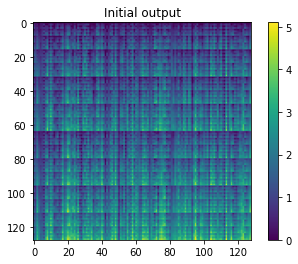

In [4]:
output = []
for pattern in all_patterns:
    output.append(list(simple_net.forward(pattern).detach()))
output = np.array(output)

plt.imshow(output)
plt.colorbar()
plt.title('Initial output')
plt.show()

In [5]:
epochs = 10**6
losses = simple_net.train(epochs, all_patterns)

100%|██████████| 1000000/1000000 [02:34<00:00, 6492.39it/s]


In [6]:
w_final = simple_net.net[0].weight.detach().numpy().flatten()

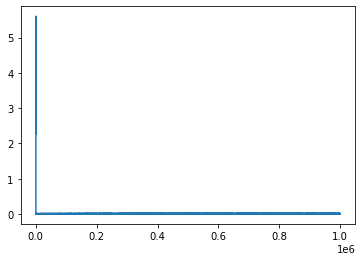

In [7]:
plt.plot(losses)

Text(0.5, 1.0, 'final weights')

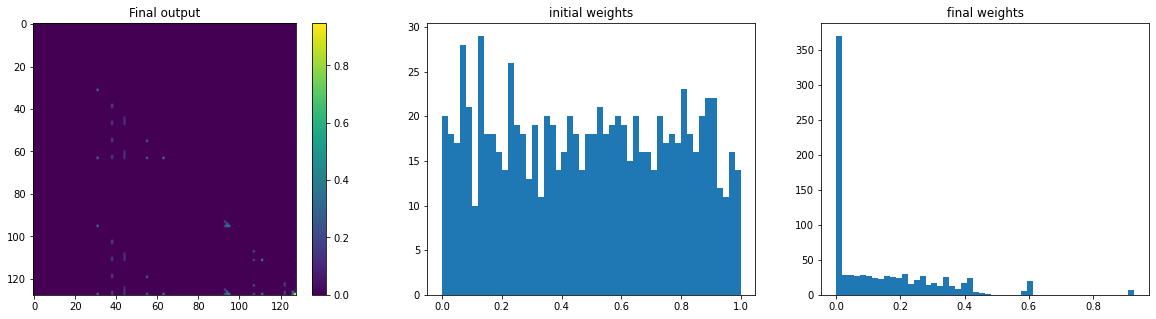

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))

output = []
for pattern in all_patterns:
    output.append(list(simple_net.forward(pattern).detach()))
output = np.array(output)

im = ax1.imshow(output,aspect='auto')
ax1.set_title('Final output')
cbar = plt.colorbar(im,ax=ax1)

ax2.hist(w_init,50)
ax2.set_title('initial weights')

ax3.hist(w_final,50)
ax3.set_title('final weights')